# Explorative analysis for extrapolation of cic savings data across multiple years

- Determine average temperature on certain days / months vs. average temperatures that we have measured.
- Extrapolate expected temperatures based on this comparison
- Determine heat demand based on these temperatures
- with COP / temperature and %-by-hp / temperature determine heat by hp extrapolated and energy consumption extrapolated


Inputs:  
etmgeg_260.txt: text file containing KNMI weather measurements in the Bilt 1901-aug2023

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from urllib.parse import urlparse
import pymysql
import os
import importlib
import seaborn as sns
import statsmodels.api as sm
importlib.reload(sns)

<module 'seaborn' from '/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/seaborn/__init__.py'>

In [4]:
# load temperature data from file
with open('./data/etmgeg_260.txt','r') as f:
    content = f.readlines()
    header = content[51].split(',')
    header = [h.strip() for h in header]
    data = [line.split(',') for line in content[53:-1]]

    df = pd.DataFrame(columns=header, data=data)

In [14]:
# get data from mysql or local
if os.path.isfile('./data/cic_data.csv'):
    # load csv file
    df_cic = pd.read_csv('./data/cic_data.csv')

else:
    MYSQL_URL = os.environ['MYSQLDEV']
    parsed_mysql_url = urlparse(MYSQL_URL)

    try:
        connection = pymysql.connect(host=parsed_mysql_url.hostname,
                                    user=parsed_mysql_url.username,
                                    password=parsed_mysql_url.password,
                                    database=parsed_mysql_url.path[1:],
                                    port=parsed_mysql_url.port,
                                    autocommit=True)
        cursor = connection.cursor()
        if cursor.connection:
            # get energyConsumption
            cursor.execute('''SELECT * FROM cic_data_daily''')
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
            df_cic = pd.DataFrame(result)
            df_cic.to_csv('./data/cic_data.csv', index=False)
    except:
        print("Error while connecting to MySQL")
    finally:
        cursor.close()
        connection.close()

In [5]:
# add date columns to dataset
df['date'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')
df['TG'] = df['TG'].astype(float)/10
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['month-day'] = df['date'].dt.strftime('%m-%d')

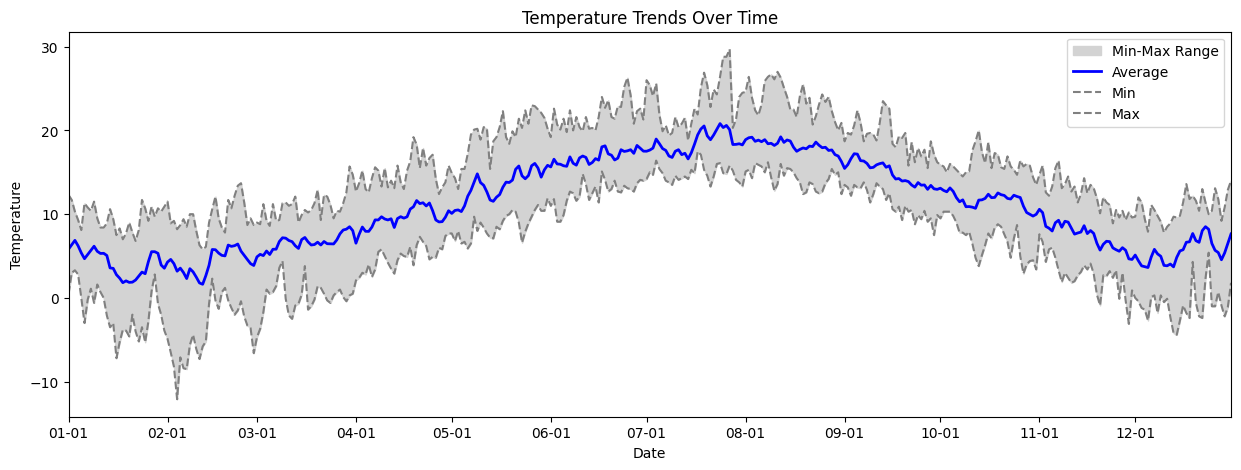

In [12]:
# create new dataframe with average temperature per day (for last 10 years)
df_year=pd.DataFrame()
df_year['month-day'] = df[df['year']==2022]['month-day']
# set month-day as index of frame
df_year = df_year.set_index('month-day')
for year in range(2012, 2023):
    df_year[f'TG-{year}'] = df[(df['year']==year) & (df['month-day']!='02-29')]['TG'].values

df_year['TG-avg'] = df_year.mean(axis=1)
df_year['TG-min'] = df_year.min(axis=1)
df_year['TG-max'] = df_year.max(axis=1)

# Plot temperature trend of the last 10 years
df_year['Date'] = pd.to_datetime(df_year.index, format='%m-%d')

# Plotting
plt.figure(figsize=(15, 5))

plt.fill_between(df_year['Date'], df_year['TG-min'], df_year['TG-max'], color='lightgrey', label='Min-Max Range')
plt.plot(df_year['Date'], df_year['TG-avg'], color='blue', linewidth=2, label='Average')
plt.plot(df_year['Date'], df_year['TG-min'], color='grey', linestyle='--', label='Min')
plt.plot(df_year['Date'], df_year['TG-max'], color='grey', linestyle='--', label='Max')


# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Trends Over Time')
plt.legend()

# Set x-axis limits to the minimum and maximum date values
plt.xlim(df_year['Date'].min(), df_year['Date'].max())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Show the plot
plt.show()

In [38]:
# Estimate and plot heat demand based on degree days
# assuming that: heat demand will go up linearly with temperature, however it's influenced by a factor which is dependant on the month (weighted degree days)
# add measured temperature to our dataframe
min_date = df_cic['date'].min()
max_date = df_cic['date'].max()

# make df_cic_avg dataframe which has all unique dates in df_cic as index ordered ascending
df_cic_avg = pd.DataFrame()
df_cic_avg['date'] = pd.date_range(min_date, max_date)

# for each date add the average min temp, average max temp, average average temp, and row count
df_cic_avg['temp_min'] = df_cic.groupby('date')['outside_temperature_min'].mean().values
df_cic_avg['temp_min_std'] = df_cic.groupby('date')['outside_temperature_min'].std().values
df_cic_avg['temp_max'] = df_cic.groupby('date')['outside_temperature_max'].mean().values
df_cic_avg['temp_max_std'] = df_cic.groupby('date')['outside_temperature_max'].std().values
df_cic_avg['temp_avg'] = df_cic.groupby('date')['outside_temperature_avg'].mean().values
df_cic_avg['temp_avg_std'] = df_cic.groupby('date')['outside_temperature_avg'].std().values
df_cic_avg['row_count'] = df_cic.groupby('date')['outside_temperature_avg'].count().values
df_cic_avg = pd.merge(df_cic_avg, df[['date','TG']], on = 'date', how='left')

# calculate differences between measured temperatures
df_cic_avg['temp_avg_diff'] = df_cic_avg['temp_avg'] - df_cic_avg['TG']

In [42]:
df_cic_avg['temp_avg_diff'].mean()

1.275107712261979

In [37]:
df_cic_avg[df_cic_avg['row_count']>15]['date'].min()

Timestamp('2022-11-30 00:00:00')

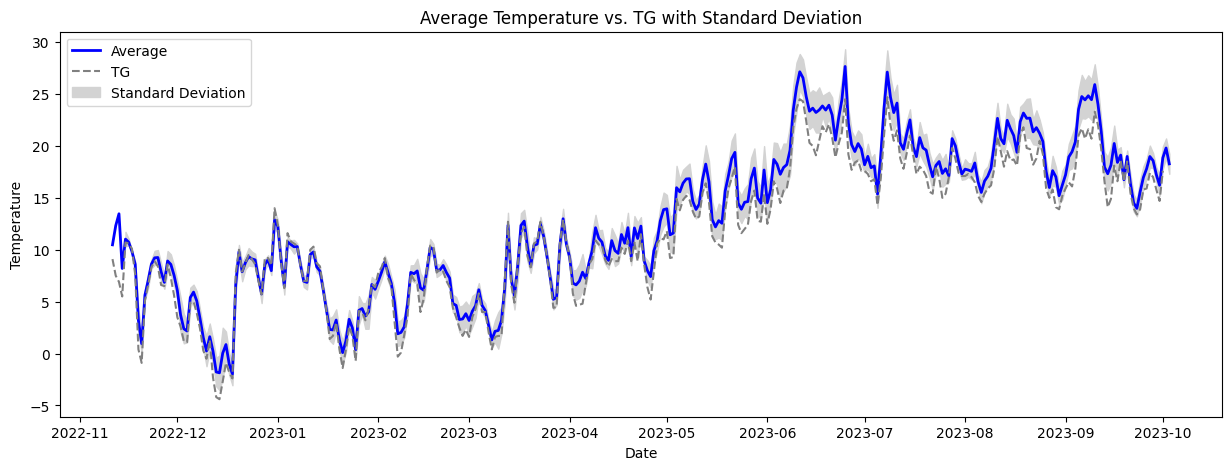

In [34]:
# Plotting
plt.figure(figsize=(15, 5))

# Plot average temperature
plt.plot(df_cic_avg['date'], df_cic_avg['temp_avg'], color='blue', linewidth=2, label='Average')

# Plot TG
plt.plot(df_cic_avg['date'], df_cic_avg['TG'], color='grey', linestyle='--', label='TG')

# Plot standard deviation as a shaded area
plt.fill_between(df_cic_avg['date'],
                 df_cic_avg['temp_avg'] - df_cic_avg['temp_avg_std'],
                 df_cic_avg['temp_avg'] + df_cic_avg['temp_avg_std'],
                 color='lightgrey', label='Standard Deviation')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Average Temperature vs. TG with Standard Deviation')
plt.legend()

# Show the plot
plt.show()

Now, we check how much heat is produced at certain outdoor temperatures and at certain days of the year.
We want to know the relation between heat demand and temperature and heat demand and month.

In [52]:
df_cic.columns

Index(['cic_id', 'created_at', 'updated_at', 'date', 'hp1_energy_consumed',
       'hp1_heat_generated', 'hp1_active', 'hp2_energy_consumed',
       'hp2_heat_generated', 'hp2_active', 'boiler_heat_generated',
       'boiler_active', 'hp1_data_availability', 'hp2_data_availability',
       'hp1_defrost', 'OLD_hp1_electrical_energy_counter',
       'OLD_hp2_electrical_energy_counter', 'OLD_hp1_thermal_energy_counter',
       'OLD_hp2_thermal_energy_counter', 'OLD_cv_energy_counter',
       'hp1_electrical_energy_counter', 'hp2_electrical_energy_counter',
       'hp_total_electrical_energy_counter', 'hp1_thermal_energy_counter',
       'hp2_thermal_energy_counter', 'hp_total_thermal_energy_counter',
       'cv_energy_counter', 'water_supply_temperature',
       'water_return_temperature', 'room_set_temperature_min',
       'room_set_temperature_max', 'room_set_temperature_avg',
       'room_temperature_min', 'room_temperature_max', 'room_temperature_avg',
       'outside_temperature_min'

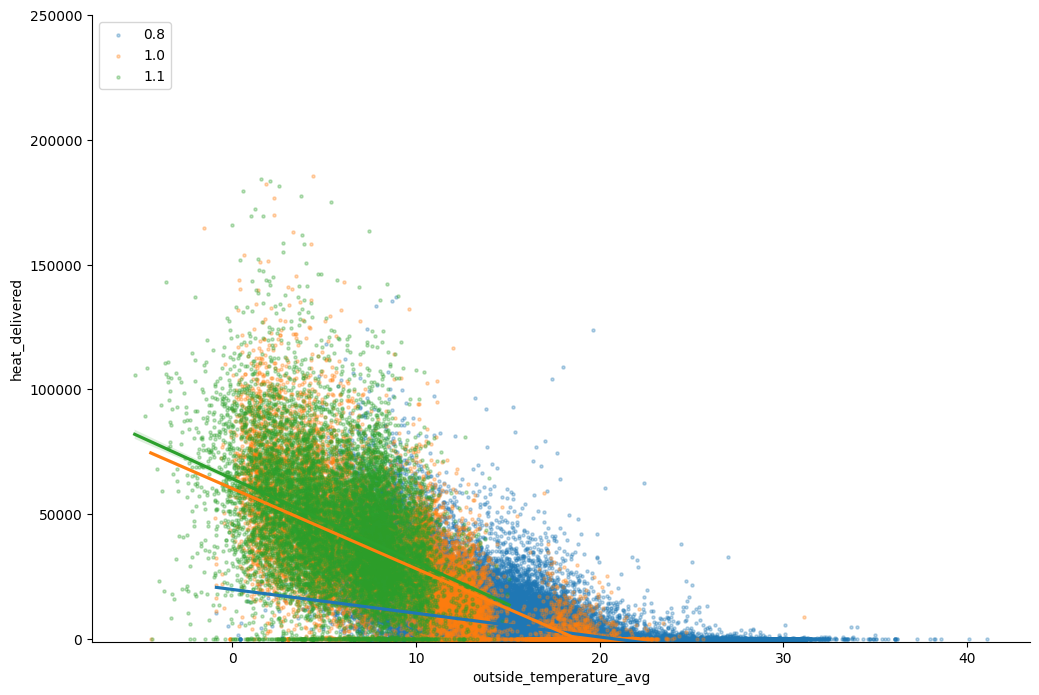

In [76]:
# add heat demand and month to dataframe
df_cic['heat_delivered'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated', 'boiler_heat_generated']].sum(axis=1).astype(float)
df_cic['month'] = df_cic['date'].dt.month
df_cic['dd_month'] = df_cic['month'].apply(lambda x: 0.8 if x in [4, 5, 6, 7, 8, 9] else (1 if x in [3, 10] else 1.1))
df_cic['outside_temperature_avg'] = df_cic['Temperature Outside (Avg)'].astype(float)

# scatter plot of heat demand per temperature including linear regression
sns.lmplot(x='outside_temperature_avg', y='heat_delivered', data=df_cic, 
           hue='dd_month', height=7, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.legend(loc='upper left')
plt.ylim([-1000, 250000])
plt.show()

In [77]:
# add percentage by hp
df_cic['perc_by_hp'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / df_cic['heat_delivered']).astype(float)
df_cic['COP'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / (df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1))).astype(float)

(-0.1, 1.1)

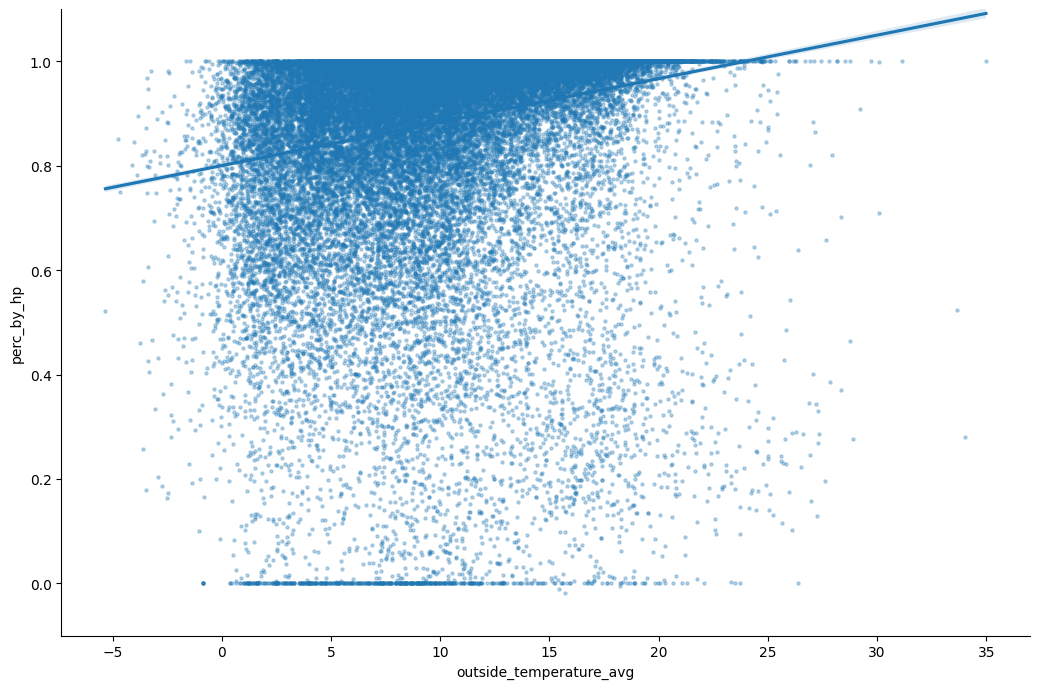

In [89]:
# scatter plot of perc_by_hp per temperature
sns.lmplot(x='outside_temperature_avg', y='perc_by_hp', 
           data=df_cic[df_cic['heat_delivered']>1000], height=7, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([-0.1, 1.1])

(0.0, 10.0)

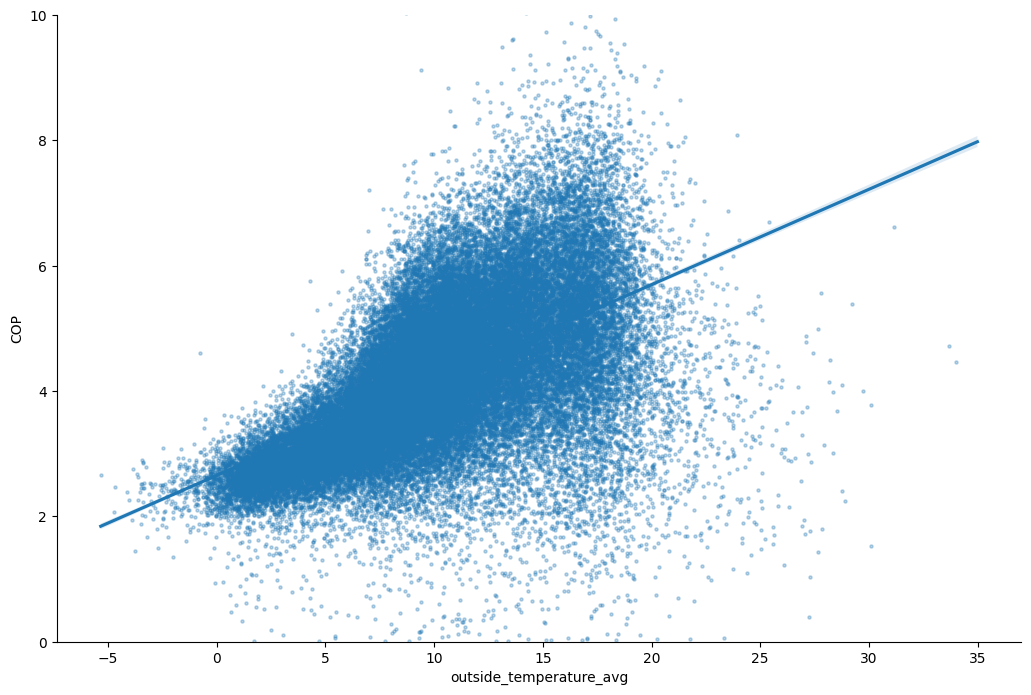

In [86]:
# scatter plot of COP per temperature
sns.lmplot(x='outside_temperature_avg', y='COP', 
           data=df_cic[(df_cic['COP']>0) & (df_cic['heat_delivered']>1000)], 
             height=7, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0,10])